# Analyzing Colorado Cannabis Sales Data 🌳 🚬

Every month, the Colorado Department of Revenue [publishes](https://www.colorado.gov/pacific/revenue/colorado-marijuana-sales-reports) county-level data on retail and medical cannabis sales in the state.

This notebook is intended to show a few things you might do in the course of gathering and analyzing data, maybe in a newsroom. It contains, or links to, code that accomplishes the following:
- Downloads a CSV version of [the state's Google Sheet](https://docs.google.com/spreadsheets/d/1br_cwfHy24d2R2bcXacb2KarOIBKGrbR/edit#gid=1659782909) and flattens the data a bit (`download.py`)
- Loads this parsed data into a `pandas` dataframe for analysis
- Downloads the Census TIGER/LINE shapefile of Colorado counties into the `raw-data` directory
- Loads this shapefile into `geopandas`
- Hits the Census Bureau API to get the most recent population estimates for Colorado counties
- Draws a choropleth map with per-capita sales data by county for the most recent year of retail sales

### Prerequisites

If you don't have one already, [grab an API key from the Census Bureau](https://www.census.gov/data/developers/guidance/api-user-guide.Query_Components.html) and save it as an [environment variable](https://en.wikipedia.org/wiki/Environment_variable) called `CENSUS_API_KEY`.

### Import dependencies

In [1]:
import os
import glob
from datetime import date
import csv
import zipfile

import requests
import pandas as pd
import geopandas as gpd
from matplotlib.ticker import FuncFormatter

In [2]:
# display plots inline
%matplotlib inline

# display floats with thousand-separator commas and no decimal points
pd.options.display.float_format = '{:,.0f}'.format

### Download the spreadsheets

Running the next cell fires a separate script, `download.py`, that grabs the latest data from the state's Google Sheet.

In [3]:
%run download

### Load the CSV into a dataframe

In [4]:
csv_file = 'co-cannabis-sales.csv'

In [5]:
df = pd.read_csv(csv_file).fillna(0).sort_values(['monthyear', 'county', 'sales_type'])

In [6]:
df.head()

,monthyear,month,year,county,amount,sales_type
0,201401,1,2014,ADAMS,683098,medical
1,201401,1,2014,ARAPAHOE,1188232,medical
2,201401,1,2014,BOULDER,3417873,medical
3,201401,1,2014,CHAFFEE,83714,medical
4,201401,1,2014,CLEAR CREEK,143736,medical


In [7]:
# check month values
sorted(df.month.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [8]:
# check year values
sorted(df.year.unique())

[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [9]:
# check county values
sorted(df.county.unique())

['ADAMS',
 'ARAPAHOE',
 'ARCHULETA',
 'BENT',
 'BOULDER',
 'CHAFFEE',
 'CLEAR CREEK',
 'CONEJOS',
 'COSTILLA',
 'CROWLEY',
 'DELTA',
 'DENVER',
 'EAGLE',
 'EL PASO',
 'FREMONT',
 'GARFIELD',
 'GILPIN',
 'GRAND',
 'GUNNISON',
 'HUERFANO',
 'JEFFERSON',
 'LA PLATA',
 'LAKE',
 'LARIMER',
 'LAS ANIMAS',
 'MESA',
 'MOFFAT',
 'MONTEZUMA',
 'MORGAN',
 'OTERO',
 'OURAY',
 'PARK',
 'PITKIN',
 'PUEBLO',
 'ROUTT',
 'SAGUACHE',
 'SAN JUAN',
 'SAN MIGUEL',
 'SEDGWICK',
 'SUM OF NR COUNTIES',
 'SUMMIT',
 'WELD']

In [10]:
# check type values
df.sales_type.unique()

array(['medical', 'retail'], dtype=object)

In [11]:
# create a date column to group by later when we plot
df['date'] = df.apply(lambda x: date(x.year, x.month, 1), axis=1)

In [12]:
# create filtered dataframes for medical and retail data
retail = df[df.sales_type == 'retail']
med = df[df.sales_type == 'medical']

### Do some basic analysis

In [13]:
# sum
df.amount.sum()

13113903021

In [14]:
# sum by year
df[['year', 'amount']].groupby('year').sum()

,amount
year,
2014,683523739
2015,995591255
2016,1307203473
2017,1507702219
2018,1545691081
2019,1747990628
2020,2191091679
2021,2228994553
2022,906114394


In [15]:
# sum by county by year
pd.pivot_table(df,
               index='county',
               values='amount',
               columns='year',
               aggfunc=sum).fillna(0)

year,2014,2015,2016,2017,2018,2019,2020,2021,2022
county,,,,,,,,,
ADAMS,"8,531,797","24,826,654","49,810,527","73,319,607","89,595,114","115,030,166","155,274,744","159,915,797","69,851,968"
ARAPAHOE,"19,083,212","68,533,185","113,890,135","124,313,953","129,801,179","153,255,179","188,314,099","199,947,743","90,943,966"
ARCHULETA,0,0,0,"6,397,396","8,848,341","10,248,743","15,536,321","16,992,084","6,372,785"
BENT,0,0,0,0,0,0,"504,288","5,526,743","3,047,746"
BOULDER,"62,935,522","82,465,474","95,408,126","99,923,326","108,277,854","116,859,122","138,333,017","143,139,122","62,633,627"
CHAFFEE,"438,160","2,067,869","3,492,699","5,422,335","5,360,100","4,330,415","6,830,041","4,353,188","1,889,454"
CLEAR CREEK,"6,095,765","6,435,080","7,414,079","7,262,477","7,425,243","7,950,847","8,852,029","10,669,939","4,945,866"
CONEJOS,0,0,"3,522,183","5,426,288","6,033,662","1,314,361",0,"10,348,829","3,792,173"
COSTILLA,0,0,"2,836,421","3,874,954","4,172,958","4,730,915","6,844,327","7,092,827","2,387,442"


In [16]:
# for all years, what percentage of total sales do the "NR Counties" contribute?
(df[df.county == 'SUM OF NR COUNTIES'].amount.sum() / df.amount.sum()) * 100

3.8800523550097097

### Let's make a line chart

Specifically, let's replicate the line chart from the state webpage:

![official chart](https://cdor.colorado.gov/sites/revenue/files/2021-01/1120_MarijuanaSalesGraph.png)

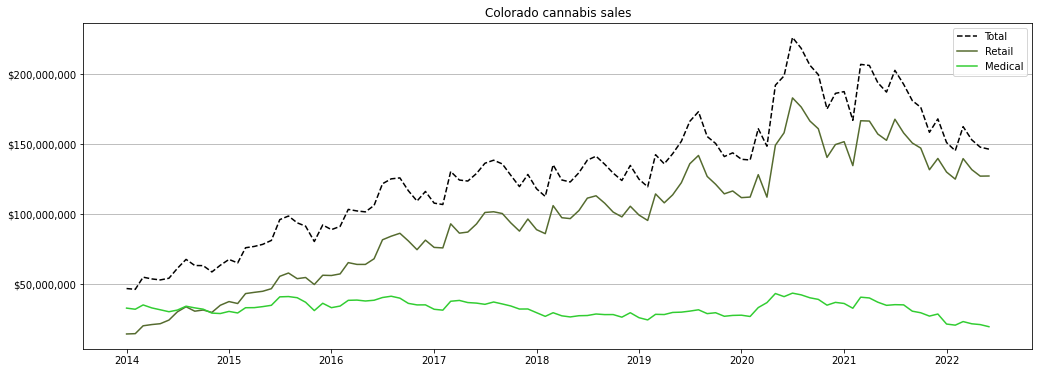

In [17]:
# chart totals by month, each type

# groupby objects for total, medical and retail dataframes
total_grouped = df[['date', 'amount']].groupby('date').sum()
med_grouped = med[['date', 'amount']].groupby('date').sum()
retail_grouped = retail[['date', 'amount']].groupby('date').sum()

# start with totals to create the chart
linechart = total_grouped.plot(color='black',
                               figsize=(17, 6),
                               title='Colorado cannabis sales',
                               linestyle='--')

# plot retail
retail_grouped.plot(ax=linechart, color='DarkOliveGreen')

# plot medical
med_grouped.plot(ax=linechart, color='LimeGreen')

# set the legend
linechart.legend(['Total', 'Retail', 'Medical'])

# turn major gridlines on
linechart.grid(True, which='major', axis='y')

# blank axis labels -- seems like it's implied?
linechart.set_xlabel('')
linechart.set_ylabel('')

# format y axis values
linechart.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:,.0f}'.format(y))) 

### A function to download a GIS file of Colorado counties

In [18]:
def get_co_county_gis_data():
    '''download a zipped shapefile of Colorado counties'''

    url = 'https://www2.census.gov/geo/tiger/TIGER2010/COUNTY/2000/tl_2010_08_county00.zip'
    fname = os.path.join('raw-data', url.split('/')[-1])    
    
    # if it's not here already ...
    if not os.path.isfile(fname):
        
        # fetch it
        r = requests.get(url)

        # and write it to file
        with open(fname, 'wb') as f:

            for block in r.iter_content(1024):
                f.write(block)

    return fname

In [19]:
# fetch the GIS data and assign what's returned (the filename) to a variable
geodata = get_co_county_gis_data()

# unzip the file
with zipfile.ZipFile(geodata, 'r') as z:
    z.extractall('raw-data')

### Load the GIS data into geopandas

In [20]:
# the shapefile naming convention is the same, so get the root filename + '.shp'
shp = geodata.split('.zip')[0] + '.shp'

# and load it into a geodataframe
gdf = gpd.read_file(shp)

In [21]:
gdf.head()

,STATEFP00,COUNTYFP00,CNTYIDFP00,NAME00,NAMELSAD00,LSAD00,CLASSFP00,MTFCC00,UR00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,geometry
0,08,013,08013,Boulder,Boulder County,06,H1,G4020,M,A,1908733293,36715760,+40.0866321,-105.3590729,"POLYGON ((-105.16615 39.91405, -105.16657 39.9..."
1,08,069,08069,Larimer,Larimer County,06,H1,G4020,M,A,6723614521,98295250,+40.6630912,-105.4821309,"POLYGON ((-105.05672 40.34928, -105.05670 40.3..."
2,08,071,08071,Las Animas,Las Animas County,06,H1,G4020,M,A,12361162110,6929979,+37.3188308,-104.0441103,"POLYGON ((-104.14318 37.75833, -104.12615 37.7..."
3,08,043,08043,Fremont,Fremont County,06,H1,G4020,M,A,3970618782,2235223,+38.4556576,-105.4214383,"POLYGON ((-105.36889 38.25940, -105.36909 38.2..."
4,08,041,08041,El Paso,El Paso County,06,H1,G4020,M,A,5508385644,7111582,+38.8273831,-104.5274718,"POLYGON ((-104.93899 38.79201, -104.93898 38.7..."


### Grab population data from the Census

In [22]:
# grab environmental variable with API key
census_api_key = os.environ.get('CENSUS_API_KEY')

In [23]:
def get_county_pop(target_year):
    
    # endpoint for latest-ish population estimates
    endpoint = f'https://api.census.gov/data/{target_year}/pep/population'
    

    # URL parameters to target info we want
    params = {
        'get': 'NAME,POP',
        'for': 'county:*',
        'in': 'state:08',
        'key': census_api_key
    }

    # request data from the API
    r = requests.get(endpoint, params=params)
    r.raise_for_status()
    
    # turn the response into Python data objects
    j = r.json()
    
    # get the headers from the first record
    headers = j[0]
    
    # return a dict of the list of data
    return [dict(zip(headers, x)) for x in j[1:]]

In [24]:
target_year = date.today().year

while True:
    try:
        cpop = get_county_pop(target_year)
        break
    except requests.exceptions.HTTPError:
        target_year -= 1

In [25]:
popfile = os.path.join('processed-data', f'colorado-county-pop-estimates-{target_year}.csv')

# write out population data to file
with open(popfile, 'w') as o:
    headers = list(cpop[0].keys())
    writer = csv.DictWriter(o, fieldnames=headers)
    writer.writeheader()
    writer.writerows(cpop)

In [26]:
# read the data into a dataframe, preserving the FIPS codes as strings
pop_df = pd.read_csv(popfile,
                     dtype={'state': str, 'county': str, 'POP': float})

In [27]:
pop_df.head()

,NAME,POP,state,county
0,"Phillips County, Colorado","4,265",08,095
1,"Archuleta County, Colorado","14,029",08,007
2,"Denver County, Colorado","727,211",08,031
3,"Kiowa County, Colorado","1,406",08,061
4,"Huerfano County, Colorado","6,897",08,055


In [28]:
# combine county and state FIPS
pop_df['fips'] = pop_df['state'] + pop_df['county']

In [29]:
pop_df.head()

,NAME,POP,state,county,fips
0,"Phillips County, Colorado","4,265",08,095,08095
1,"Archuleta County, Colorado","14,029",08,007,08007
2,"Denver County, Colorado","727,211",08,031,08031
3,"Kiowa County, Colorado","1,406",08,061,08061
4,"Huerfano County, Colorado","6,897",08,055,08055


### Map: Per-capita sales analysis

We'll look at the most recent retail sales data -- [checking this researcher's work, basically](https://www.thecannabist.co/2018/02/09/colorado-marijuana-sales-southern-border/98669/). Our steps:

1. Merge our GIS dataframe with the population data
2. Merge the result with the cannabis sales data
3. Calculate the per-capita rate
4. Plot on a map

In [30]:
geo_pop_df = pd.merge(gdf,
                      pop_df,
                      how='left',
                      left_on='CNTYIDFP00',
                      right_on='fips')[['fips', 'NAME00', 'geometry', 'POP']]

In [31]:
geo_pop_df.head()

,fips,NAME00,geometry,POP
0,08013,Boulder,"POLYGON ((-105.16615 39.91405, -105.16657 39.9...","326,196"
1,08069,Larimer,"POLYGON ((-105.05672 40.34928, -105.05670 40.3...","356,899"
2,08071,Las Animas,"POLYGON ((-104.14318 37.75833, -104.12615 37.7...","14,506"
3,08043,Fremont,"POLYGON ((-105.36889 38.25940, -105.36909 38.2...","47,839"
4,08041,El Paso,"POLYGON ((-104.93899 38.79201, -104.93898 38.7...","720,403"


In [32]:
geo_pop_df['NAME00'] = geo_pop_df['NAME00'].str.upper()

In [33]:
# filter to get latest retail sales data
latest_retail = retail[retail['year'] == target_year]

In [34]:
# group by county and sum the amounts
latest_retail_group = latest_retail[['county', 'amount']].groupby('county').sum().reset_index()

In [35]:
# merge that with the dataframe we merged earlier
latest_retail_map = pd.merge(geo_pop_df,
                             latest_retail_group,
                             how='left',
                             left_on='NAME00',
                             right_on='county')[['fips', 'NAME00', 'geometry', 'POP', 'amount']]

In [36]:
latest_retail_map.head()

,fips,NAME00,geometry,POP,amount
0,08013,BOULDER,"POLYGON ((-105.16615 39.91405, -105.16657 39.9...","326,196","102,617,150"
1,08069,LARIMER,"POLYGON ((-105.05672 40.34928, -105.05670 40.3...","356,899","90,982,853"
2,08071,LAS ANIMAS,"POLYGON ((-104.14318 37.75833, -104.12615 37.7...","14,506","55,815,043"
3,08043,FREMONT,"POLYGON ((-105.36889 38.25940, -105.36909 38.2...","47,839",NaN
4,08041,EL PASO,"POLYGON ((-104.93899 38.79201, -104.93898 38.7...","720,403",NaN


In [37]:
# calculate the per-capita rate
latest_retail_map['per_capita'] = latest_retail_map['amount'] / latest_retail_map['POP']

In [38]:
latest_retail_map.sort_values('per_capita', ascending=False).head()

,fips,NAME00,geometry,POP,amount,per_capita
2,08071,LAS ANIMAS,"POLYGON ((-104.14318 37.75833, -104.12615 37.7...","14,506","55,815,043","3,848"
44,08091,OURAY,"POLYGON ((-107.95565 38.22649, -107.95659 38.2...","4,952","6,874,935","1,388"
24,08023,COSTILLA,"POLYGON ((-105.73841 37.30676, -105.73842 37.3...","3,887","4,730,915","1,217"
29,08083,MONTEZUMA,"POLYGON ((-109.04583 37.32684, -109.04584 37.3...","26,183","23,177,836",885
56,08019,CLEAR CREEK,"POLYGON ((-105.72413 39.81902, -105.72388 39.8...","9,700","7,939,056",818


<AxesSubplot:>

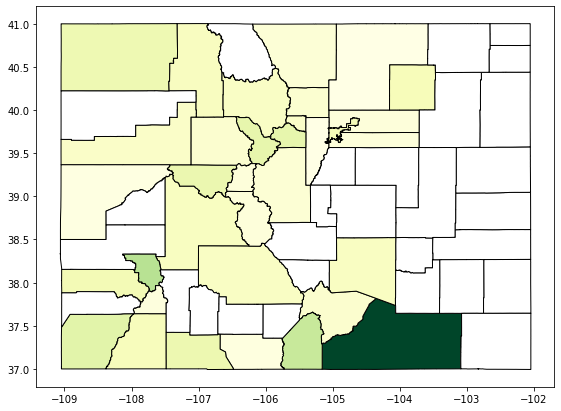

In [39]:
# plot on a map
latest_retail_map.plot(column='per_capita',
                       edgecolor='black',
                       cmap='YlGn', 
                       missing_kwds={'color': 'white'},
                       figsize=(13,7))